                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

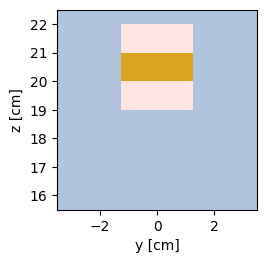

In [1]:
"""
CATHERINE DICKSTEIN
JACK SZYPROWSKI
8-10-23
"""

%matplotlib inline
import openmc
import os
import numpy as np

#MATERIALS
#Creating bronze material for cylinder
castBronze = openmc.Material(1, "castBronze")
castBronze.add_element("Cu", 0.90)
castBronze.add_element("Sn", 0.10)
castBronze.temperature = 293 #K
castBronze.set_density("g/cm3", 8.77)

#Creating nitrogen
nitrogen = openmc.Material(2, "nitrogen")
nitrogen.set_density("g/cm3", 0.0012506)
nitrogen.add_element('N', 2.0)
nitrogen.temperature = 293 #K

#Creating oxygen
oxygen = openmc.Material(3, "oxygen")
oxygen.set_density("g/cm3", 0.001429)
oxygen.add_element('O', 2.0)
oxygen.temperature = 293 #K

#Creatiing argon
argon = openmc.Material(4, "argon")
argon.set_density("g/cm3", 0.0017837)
argon.add_element('Ar', 1.0)
argon.temperature = 293 #K

#Creating Carbon Dioxide
CO2 = openmc.Material(5, "CO2")
CO2.set_density("g/cm3", 0.001976)
CO2.add_element('C', 1.0)
CO2.add_element('O', 2)
CO2.temperature = 293 #K

#Adds all gasses into one material
airmix = openmc.Material.mix_materials([nitrogen, oxygen, argon, CO2], [0.7808, 0.2095, 0.0093, 0.0004], 'ao')

#Exporting materials
mats = openmc.Materials([castBronze, nitrogen, oxygen, argon, CO2, airmix])
mats.export_to_xml()

# GEOMETRY
cylWidth = 1.01092
cylDiam = 2.51968

#Making cylinder
cylinderSurface = openmc.ZCylinder(r=(cylDiam/2), boundary_type='transmission')
upperSurface = openmc.ZPlane(z0=(20+cylWidth), boundary_type='transmission')
lowerSurface = openmc.ZPlane(z0=20, boundary_type='transmission')

#Creates cylinder region
cylinderInside = -cylinderSurface & -upperSurface & +lowerSurface

# Create cells, mapping materials to cells
cylinder = openmc.Cell(name='cylinder')
cylinder.fill = castBronze
cylinder.region = cylinderInside

#Create cylinder behind to count flux
BtestcylinderSurface = openmc.ZCylinder(r=(cylDiam/2), boundary_type='transmission')
BtestupperSurface = openmc.ZPlane(z0=20, boundary_type='transmission')
BtestlowerSurface = openmc.ZPlane(z0=19, boundary_type='transmission')

BtestcylinderInside = -BtestcylinderSurface & -BtestupperSurface & +BtestlowerSurface

# Create cells, mapping materials to cells
Btestcylinder = openmc.Cell(name='Btestcylinder')
Btestcylinder.fill = airmix
Btestcylinder.region = BtestcylinderInside

#Create cylinder in front to count flux
TtestcylinderSurface = openmc.ZCylinder(r=(cylDiam/2), boundary_type='transmission')
TtestupperSurface = openmc.ZPlane(z0=(21+cylWidth), boundary_type='transmission')
TtestlowerSurface = openmc.ZPlane(z0=(20+cylWidth), boundary_type='transmission')

TtestcylinderInside = -TtestcylinderSurface & -TtestupperSurface & +TtestlowerSurface

# Create cells, mapping materials to cells
Ttestcylinder = openmc.Cell(name='Ttestcylinder')
Ttestcylinder.fill = airmix
Ttestcylinder.region = TtestcylinderInside

#Create a box of air for cylinders to be in
xmin = openmc.XPlane(-60.0, boundary_type='vacuum')
xmax = openmc.XPlane(60.0, boundary_type='vacuum')
ymin = openmc.YPlane(-60.0, boundary_type='vacuum')
ymax = openmc.YPlane(60.0, boundary_type='vacuum')
zmin = openmc.ZPlane(-60.0, boundary_type='vacuum')
zmax = openmc.ZPlane(60.0, boundary_type='vacuum')
box = +xmin & -xmax & +ymin & -ymax & +zmin & -zmax

#Making regions and assigning to cells for box
air_region = ~cylinderInside & ~BtestcylinderInside & ~TtestcylinderInside & box
air = openmc.Cell(name='air')
air.fill = airmix
air.region = air_region

#Create universe, export geometry
root_universe = openmc.Universe(cells=[cylinder, Ttestcylinder, Btestcylinder, air])
geom = openmc.Geometry(root_universe)                    
geom.export_to_xml()  

#Graphs Geometry
root_universe.plot(width=(7,7), basis='yz', origin=(0,0,19), color_by="cell", colors={Ttestcylinder: 'mistyrose', Btestcylinder: 'mistyrose', cylinder: 'goldenrod', air: 'lightsteelblue'})

#SETTINGS
settings = openmc.Settings()
settings.particles = 10000
settings.batches = 10
settings.inactive = 0

#Creates source
r = openmc.stats.PowerLaw(0.0, 2, 1.0)
phi = openmc.stats.Uniform(0.0, 2 * np.pi)
z = openmc.stats.Discrete([1.0], [0.0])
spatial_dist = openmc.stats.CylindricalIndependent(r, phi, z)
source = openmc.Source(space=spatial_dist)

#Sets source type and energy
source.angle = openmc.stats.Monodirectional([0, 0, 1])
source.energy = openmc.stats.Discrete([0.025], [1.0])
source.strength = 1
settings.source = source

#Exports settings
settings.run_mode = 'fixed source'
settings.export_to_xml()

#TALLIES
#Creates a filter on the top of the sample
Ttest_filter = openmc.CellFilter(Ttestcylinder)

#Counts the amount of initial flux
Ttest_tally = openmc.Tally(name="flux of Top test cylinder")
Ttest_tally.filters = [Ttest_filter]
Ttest_tally.scores = ['flux']

#Creates a filter on the bottom of the sample
Btest_filter = openmc.CellFilter(Btestcylinder)

#Counts the amount of  flux transmitted
Btest_tally = openmc.Tally(name="flux of Bottom test cylinder")
Btest_tally.filters = [Btest_filter]
Btest_tally.scores = ['flux']

#Export Tallies
tallies = openmc.Tallies([Ttest_tally, Btest_tally])
tallies.export_to_xml()

#Run Code
model=openmc.model.Model(geom, mats, settings, tallies)
openmc.run()

#Prints results
!cat tallies.out